In [1]:
%matplotlib notebook

Run model for 4000 years


<IPython.core.display.Javascript object>


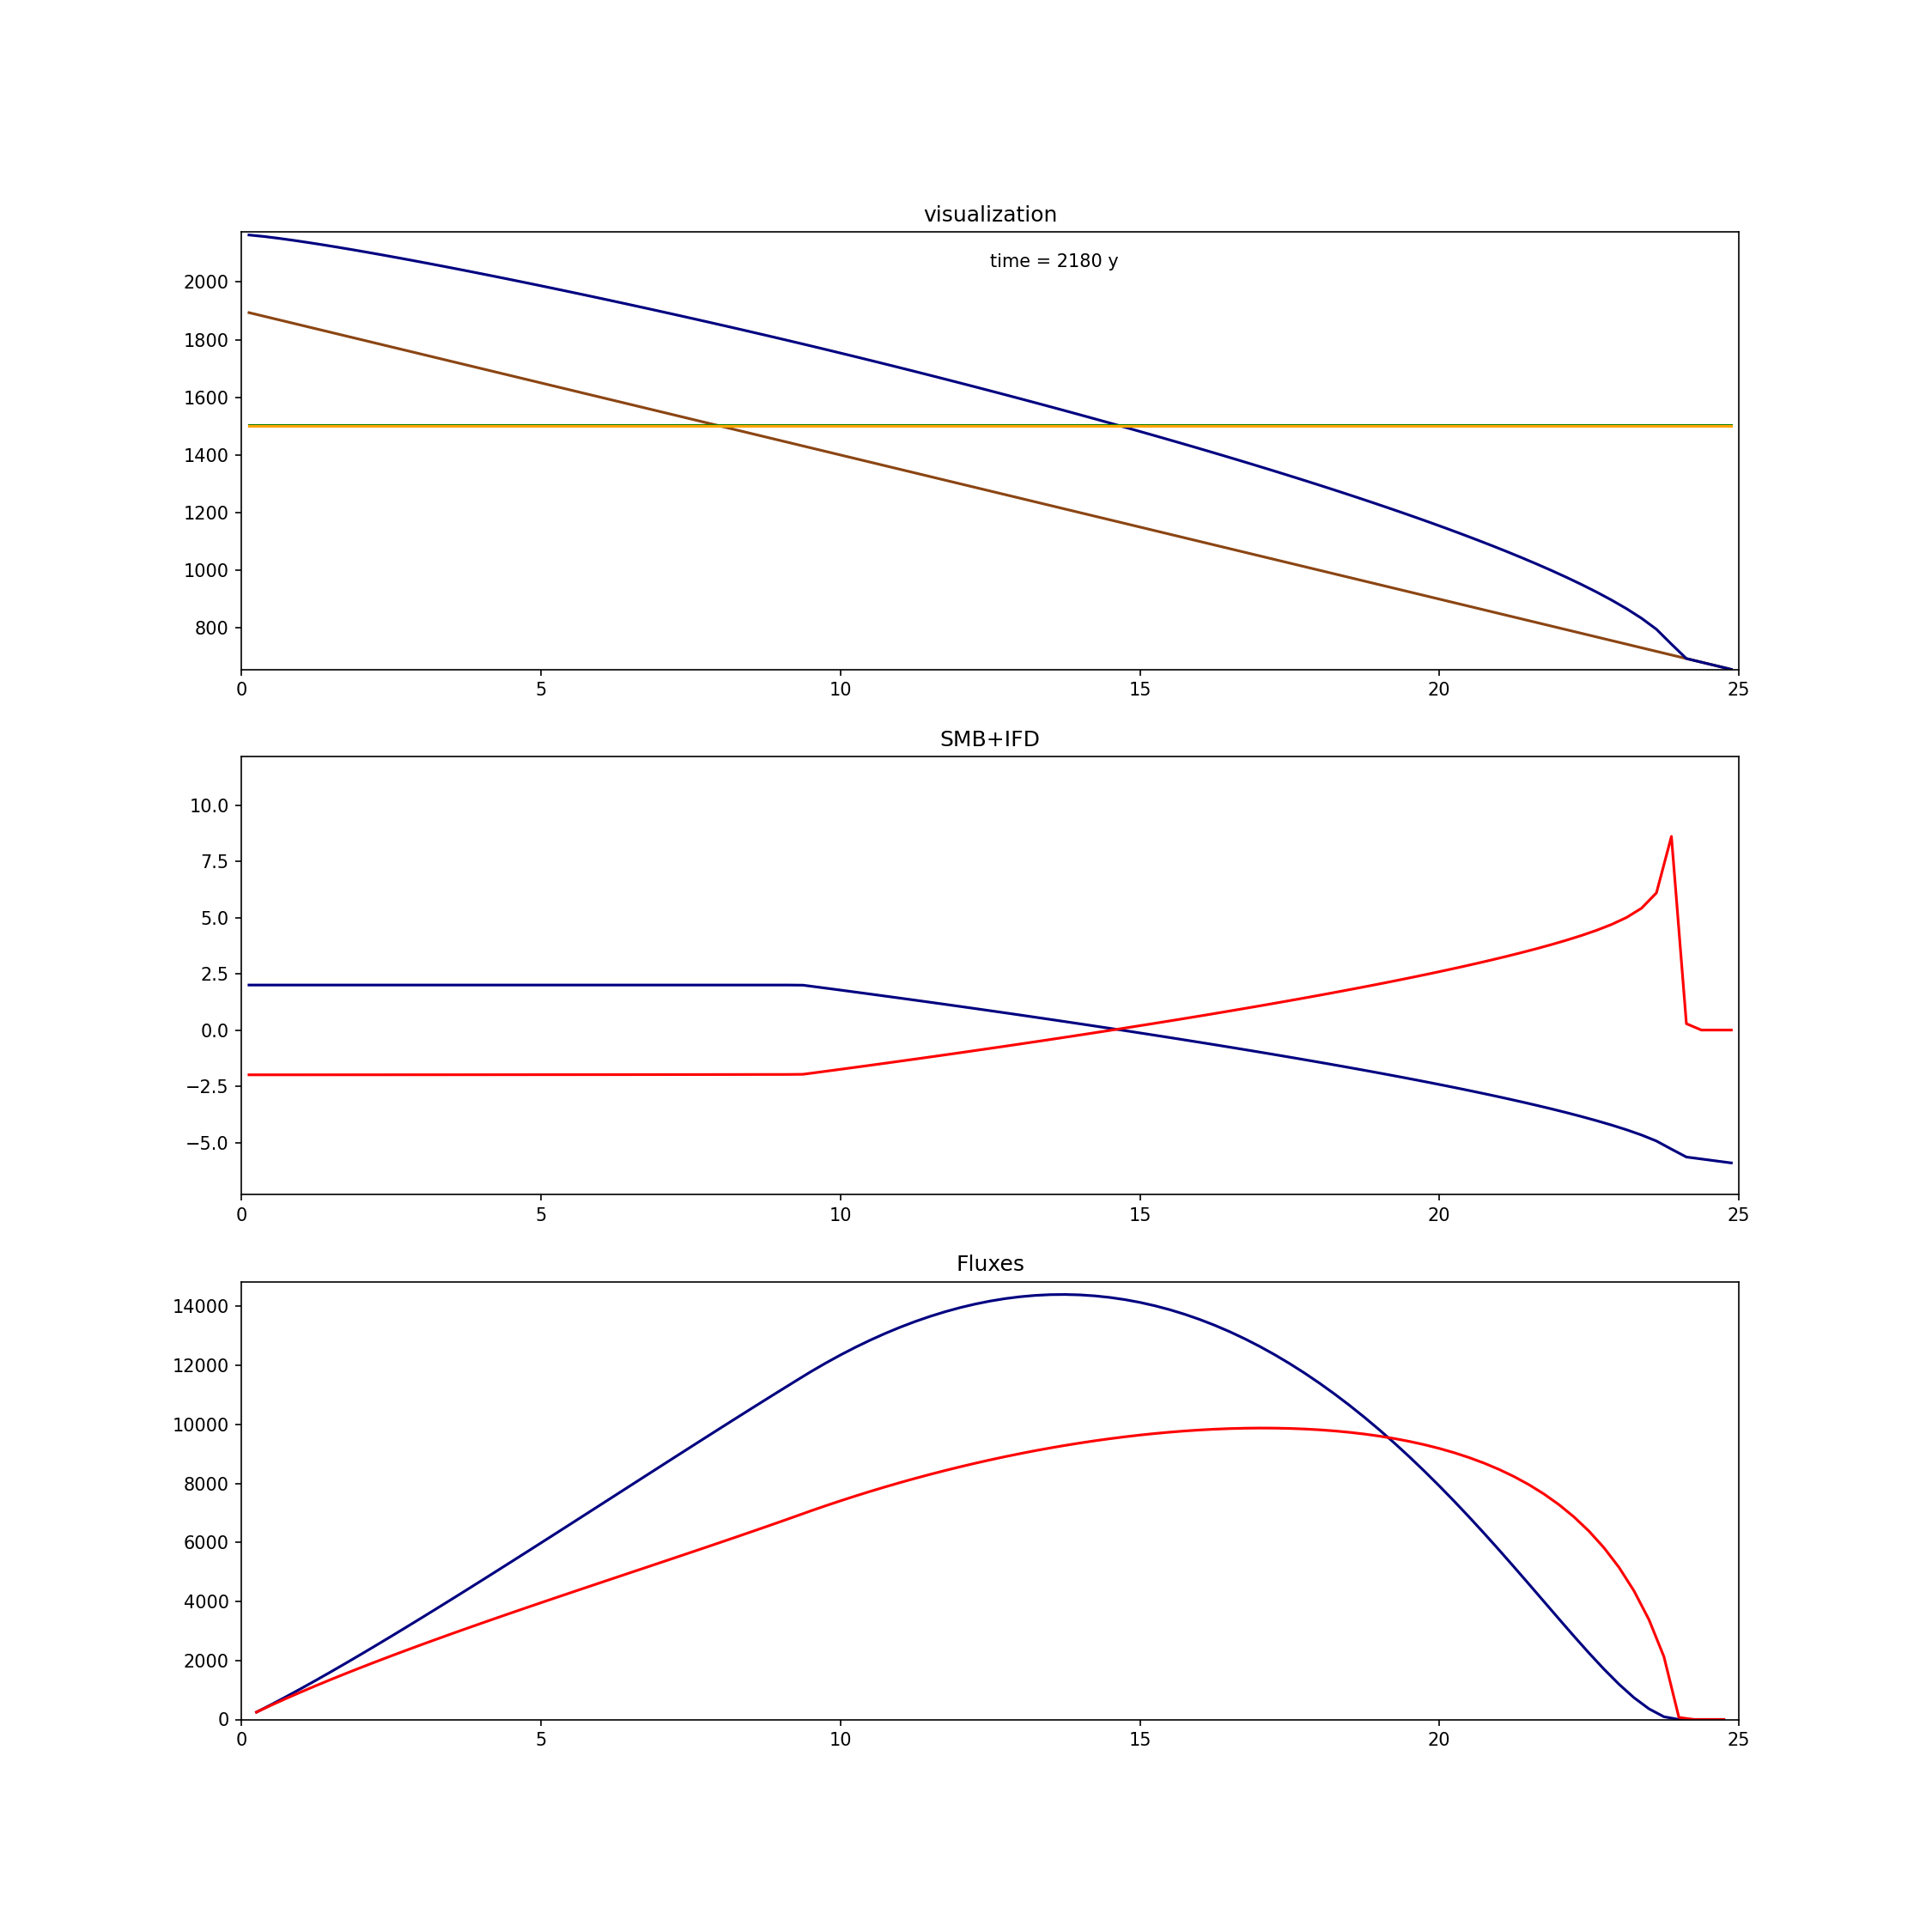

In [13]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Nov  8 16:49:55 2019
@author: wvdberg
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

totL  = 25000 # total length of the domain [m]
dx    =   250 # grid size [m]
ntpy  =   200 # number of timesteps per year

ZeroFluxBoundary = True # either no-flux (True) or No-6ary (False)
FluxAtPoints     = False # if true, the ice flux is calculated on grid points, 
                        #  otherwise on half points
StopWhenOutOfDomain = True                        
                        
ndyfigure = 5           # number of years between a figure frame                        


rho   =  917.      # kg/m3
g     =    9.80665 # m/s2
fd    =    1.9E-24 # # pa-3 s-1 # this value and dimension is only correct for n=3
fs    =    5.7E-20 # # pa-3 m2 s-1 # this value and dimension is only correct for n=3


elalist = np.array([1700., 1600.,1500.,1650.])  # m -> default 1800., 1750., 1900., 1800.,
elayear = np.array([1000., 1000.,1000.,1000.])  # years    
dbdh    =    0.007    # [m/m]/yr
maxb    =    2.      # m/yr

cd    = 2/5*(rho*g)**3*fd  # <<< this must be adjusted according to your discretisation
cs    = (rho*g)**3*fs  # <<< this must be adjusted according to your discretisation
slope = 0.05
bmax = 1900.
def get_bedrock(xaxis):
    # here you put in your own equation that defines the bedrock
    bedrock = bmax - xaxis*slope
    return bedrock
def glacier_mass(hice,dx):
    return np.sum(hice)*dx*rho

# Start calculations
# constants that rely on input
nx    = int(totL/dx)   #number of grid points
dx    = totL/nx        #width of grid points     
xaxis = np.linspace(0,totL,nx,False) + dx*0.5
xhaxs = np.linspace(dx,totL,nx-1,False) / 1000.

bedrock = get_bedrock(xaxis)

dt    = 365.*86400./ntpy # in seconds!

hice   = np.zeros(nx)    # ice thickness
dhdx   = np.zeros(nx)    # the local gradient of h
fluxd  = np.zeros(nx+2)  # this will be the flux per second!!!!
fluxs  = np.zeros(nx+2)  # this will be the flux per second!!!!
dhdtif = np.zeros(nx)    # change in ice thickness due to the ice flux, per second
smb    = np.zeros(nx)    # surface accumulation
# preparations for the ela-selection
# elaswch is a list of time steps on which a new ela value should be used.
nyear    = int(np.sum(elayear))
if np.size(elalist) != np.size(elayear):
    print("the arrays of elalist and elayear does not have the same length!")
    exit()
else:
    elaswch = np.zeros(np.size(elalist))
    for i in range(0,np.size(elaswch)-1):
        elaswch[i+1] = elaswch[i] + (elayear[i]*ntpy) #adds number of years * time steps per year to the list of steps
    ela     = elalist[0]
        
# preparations for the animation
nframes  = nyear//ndyfigure + 1
eqlinemem = np.zeros([nx,nframes])
elalinemem = np.zeros([nx,nframes])
hsurfmem = np.zeros([nx,nframes])
smbmem   = np.zeros([nx,nframes])
ifdmem   = np.zeros([nx,nframes])
fldmem   = np.zeros([nx-1,nframes])
flsmem   = np.zeros([nx-1,nframes])
iframes  = 0

print("Run model for {0:3d} years".format(nyear))
hice_l=np.zeros((ntpy*nyear + 1,1))
mass_l=np.zeros((ntpy*nyear + 1,1))
for it in range(ntpy*nyear + 1):
    h = hice + bedrock
    dhdx[:-1]  = (h[1:]-h[:-1])/dx # so 0 is at 1/2 actually
    # note that flux[1] is at the point 1/2
    fluxd[1:-2] = cd * dhdx[:-1]**3 * ( ((hice[1:])+(hice[:-1])) * 0.5 )**5
    fluxs[1:-2] = cs * dhdx[:-1]**3 * ( ((hice[1:])+(hice[:-1])) * 0.5 )**3
    # derive flux convergence
    dhdtif[:]  = (fluxd[1:-1]-fluxd[:-2] + fluxs[1:-1]-fluxs[:-2])/dx
    # first update ela (once a year)
    if it%ntpy == 0:
    # lists the elements of elaswch that are equal or smaller than it
        [ielanow] = np.nonzero(elaswch<=it) 
    # the last one is the current ela
        ela       = elalist[ielanow[-1]]        
    smb[:] = (h-ela)*dbdh
    smb[:] = np.where(smb>maxb, maxb, smb) 
    
    dhice = smb/ntpy + dt*dhdtif
    hice   += dhice
    hice[:] = np.where(hice<0., 0., hice) # remove negative ice thicknesses
    
    if ZeroFluxBoundary == False:
        hice[0] = hice[-1] = 0.
    hice_l[it]=[i for i, e in enumerate(hice) if e != 0][-1]
    mass_l[it]=glacier_mass(hice,dx)

    if it%(ndyfigure*ntpy) == 0:
        
        hsurfmem[:,iframes] = hice + bedrock
        eqlinemem[:,iframes] = h[np.argmin(np.absolute(smb-dhdtif[:]*365.*86400.))]
        elalinemem[:,iframes] = ela*np.ones(nx)
        smbmem[:,iframes]   = smb
        ifdmem[:,iframes]   = dhdtif[:]*365.*86400.
        fldmem[:,iframes]   = -fluxd[1:-2]*365.*86400.
        flsmem[:,iframes]   = -fluxs[1:-2]*365.*86400.
        iframes            += 1
        if StopWhenOutOfDomain:
            if hice[-1]>1.:
                print("Ice at end of domain!")
                exit()
#print(elalinemem)
# at this point, the simulation is completed.        
# the following is needed to make the animation        
fig  = plt.figure(figsize=(15,15))

ax1  = fig.add_subplot(311, autoscale_on=False, xlim=(0,totL/1000.), \
                    ylim=(np.min(bedrock),np.max(hsurfmem)+10.),title="visualization")
mina2 = min(np.min(smbmem),np.min(ifdmem))
maxa2 = max(np.max(smbmem),np.max(ifdmem))
ax2   = fig.add_subplot(312, autoscale_on=False, xlim=(0,totL/1000.), \
                    ylim=(mina2,maxa2), title="SMB+IFD")
mina3 = min(np.min(fldmem),np.min(flsmem))
maxa3 = max(np.max(fldmem),np.max(flsmem))
ax3   = fig.add_subplot(313, autoscale_on=False, xlim=(0,totL/1000.), \
                    ylim=(mina3,maxa3),title="Fluxes")

# define the line types
bedrline, = ax1.plot([],[],'-', c='saddlebrown') 
hsrfline, = ax1.plot([],[],'-', c='navy')
eqline,=ax1.plot([],[],'-',c='g')
elaline,=ax1.plot([],[],'-',c='orange')
time_template = 'time = %d y'
time_text = ax1.text(0.5, 0.92, '', transform=ax1.transAxes )
smbline,  = ax2.plot([],[],'-', c='navy')
ifdline,  = ax2.plot([],[],'-', c='red')
fxdline,  = ax3.plot([],[],'-', c='navy')
fxsline,  = ax3.plot([],[],'-', c='red')

# initialize the animation
def init_anim():
    bedrline.set_data([], [])
    hsrfline.set_data([], [])
    eqline.set_data([],[])
    elaline.set_data([],[])
    time_text.set_text('')
    smbline.set_data([], [])
    ifdline.set_data([], [])
    fxdline.set_data([], [])
    fxsline.set_data([], [])
    return bedrline, hsrfline,eqline,elaline, time_text, smbline, ifdline, fxdline, fxsline

# update the animation with data for saved frame #tf
def animate(tf):
    bedrline.set_data(xaxis/1000., bedrock)
    hsrfline.set_data(xaxis/1000., hsurfmem[:,tf])
    eqline.set_data(xaxis/1000.,eqlinemem[:,tf])
    elaline.set_data(xaxis/1000.,elalinemem[:,tf])
    time_text.set_text(time_template % int(tf*ndyfigure))
    smbline.set_data(xaxis/1000.,  smbmem[:,tf])
    ifdline.set_data(xaxis/1000.,  ifdmem[:,tf])
    fxdline.set_data(xhaxs      ,  fldmem[:,tf])
    fxsline.set_data(xhaxs      ,  flsmem[:,tf])
    return bedrline, hsrfline,eqline,elaline, time_text, smbline, ifdline, fxdline, fxsline
simdict={}
simdict['totL']=totL
simdict['dx']=dx
simdict['ntpy']=ntpy
simdict['elalist']=elalist
simdict['elayear']=elayear
simdict['dbdh']=dbdh
simdict['maxb']=maxb
simdict['slope']=slope
simdict['bmax']=bmax
simdict['hice']=hice_l
simdict['mass']=mass_l
simname='sim3'
np.save(simname,simdict,allow_pickle=True)
# call and run animation
ani = animation.FuncAnimation(fig, animate, np.arange(iframes),\
         interval=25, blit=True, init_func=init_anim, )     
from numpy import save
np.save('sim1.npy',simdict,allow_pickle=True)
plt.show()
